In [1]:
from scipy.optimize import ridder
import torch
import matplotlib.pyplot as plt
from MINE import MINE
from tqdm import tqdm
from torch.autograd import Variable
import numpy as np

import random
import os
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
seed_torch()

model = MINE(3, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [2]:
#生成联合高斯x,y
cov = [[1,.5,.5,.5,.5],
       [.5,1,.5,.5,.5],
       [.5,.5,1,.5,.5],
       [.5,.5,.5,1,.5],
       [.5,.5,.5,.5,1]]
cov_p = [[1,.5,.5,0,0],
         [.5,1,.5,0,0],
         [.5,.5,1,0,0],
         [0,0,0,1,.5],
         [0,0,0,.5,1]]
gaussian_xy = np.random.multivariate_normal((0,0,0,0,0),cov,20000)
x = gaussian_xy[:,0:3]
y = gaussian_xy[:,3:5]
y_shuffled = np.random.permutation(y)

x = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=False)#训练数据都是计算图里的叶节点，不需要梯度
y = Variable(torch.from_numpy(y).type(torch.FloatTensor), requires_grad=False)
y_shuffled = Variable(torch.from_numpy(y_shuffled).type(torch.FloatTensor), requires_grad=False)

In [3]:
#自定义数值求解函数 done
def solve_f_star(y):
    x = []
    for y_ in y[:,0]:
        y_ = y_.item()
        def f_star(x):
            return np.log(x)+1-y_
        res = ridder(f_star,0,np.exp(y_),xtol=1e-2)
        x.append(res)
    return torch.tensor(x, requires_grad=False)

skl = []
num_epoch = 400
for epoch in tqdm(range(num_epoch)):
    pred_xy = model(x, y)
    pred_x_y = model(x, y_shuffled)

    loss1 = - torch.mean(pred_xy)
    t1 = solve_f_star(pred_x_y).reshape((-1,1))
    loss2 = torch.mean(t1*pred_x_y)
    loss2_actual = torch.mean(t1)
    '''
    plot_loss.append(loss1.data.numpy())
    print(loss1.item())
    '''
    loss = loss1 + loss2
    skl.append((-loss1-loss2_actual).data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()


  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
 16%|█▌        | 62/400 [00:21<01:54,  2.96it/s]C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
100%|██████████| 400/400 [02:16<00:00,  2.94it/s]


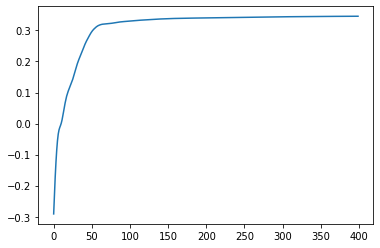

In [4]:
plot_x = np.arange(len(skl))
plot_y = np.array(skl)
plt.plot(plot_x, plot_y)

In [5]:
cov = np.array(cov)
cov_p = np.array(cov_p)
res = 0.5*(np.log(np.linalg.det(cov_p))-np.log(np.linalg.det(cov))+(np.linalg.inv(cov_p).dot(cov)-np.identity(5)).trace())
res

0.34657359027997253